<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/experiment_model_improvement_v8_SE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DA CV FER

Objective
 - extending the version (v5_SE notebookd/11_04 model) of non_dann to dann and dann_ewc
 - Use of race dataset as validation dataloader (ds_expw_crop_race.py => EXPWCROPRACE, DatasetEXPWRACECROP)

 - use Squeeze and Excite on basic pretrained models to check accuracy - https://www.robots.ox.ac.uk/~albanie/pytorch-models.html - VGG vgg_vd_face_sfew (weights)
 - Previously from v5/ v5_SE
    - can achieve more than 55% + accuracy
    - lr of 0.001 gives good accuarcy

Observations
  - Non DANN
    - SFEW VAL: Average loss: 0.1119, Accuracy: 230/419 (54.89%)
    - RACE DS: Average loss: 0.2361, Accuracy: 2606/8458 (30.81%)
  - DANN
    - SFEW VAL: Average loss: 0.1122, Accuracy: 222/419 (52.98%)
    - RACE DS: Average loss: 0.2429, Accuracy: 2270/8458 (26.84%)
  - EWC DANN
    - SFEW VAL: Average loss: 0.1330, Accuracy: 215/419 (51.31%)
    - RACE DS: Average loss: 0.2459, Accuracy: 2695/8458 (31.86%)

Next Steps
  - lr finder
  - EWC only for the self.feature_extractor and self.class_classifier block
Models
  - 14_04


## Initializations
Cloning Repo, Dependencies installation, Libraries import and Config Initialization

### Cloning Repo, Installing dependencies

In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 489, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 489 (delta 0), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (489/489), 37.73 MiB | 20.74 MiB/s, done.
Resolving deltas: 100% (274/274), done.


In [2]:
!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Installs from files
from da_cv_fer.data_config import DataConfig
# from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP

# from da_cv_fer.ds_expw_crop import EXPWCROP
from da_cv_fer.ds_expw_crop_race import EXPWCROPRACE
# from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import *
# from da_cv_fer.model_DANN import DANN
# from da_cv_fer.model_DANN_Bespoke import DANNBespoke
from da_cv_fer.run_config import RunConfig
# from da_cv_fer.train import *
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np


### Initializing Configs

In [4]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

##  Dataset
- SFEW Dataset
- Creating Dataloader object


In [5]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Creating Dataloader

In [6]:
sfew = DatasetSFEWCROP()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew created successfully.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Disgust.zip Disgust
...completed for dataset/sfew/Train/Disgust.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/Angry.zip
dataset/sfew/Train Surprise.zip Surprise
...completed for dataset/sfew/Train/Surprise.zip
dataset/sfew/Train Fear.zip Fear
...completed for dataset/sfew/Train/Fear.zip
dataset/sfew/Train Happy.zip Happy
...completed for dataset/sfew/Train/Happy.zip
dataset/sfew/Train Neutral.zip Neutral
...completed for dataset/sfew/Train/Ne

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Example Images

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


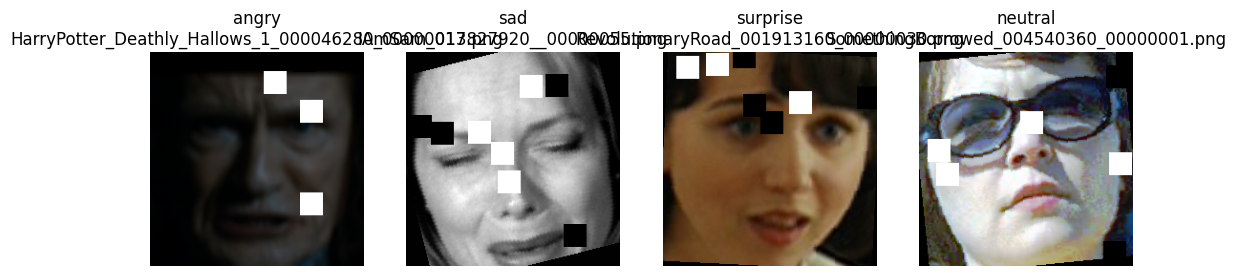

In [7]:
show_batch(sfew_train_loader,sfew.labels,4, normalized = False)

In [8]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
data_loader = {'source' : sfew_loader}
source_name = data_loader['source']['name']

## Model Initialization

### Simple Model_V5_SE
- including dann
- including grl
- including SE

In [9]:

import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F


class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [10]:
model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

In [11]:
model_pretrained

Vgg_vd_face_sfew_dag(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_m

In [12]:
import torch.nn as nn
import torch
from torch.autograd import Function
import torch.nn.functional as F


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()
        y = self.avg_pool(x).view(batch_size, num_channels)
        y = self.fc(y).view(batch_size, num_channels, 1, 1)
        return x * y.expand_as(x)

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG_SE(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG_SE, self).__init__()
        #---------------------Feature Extractor Network------------------------#
        list_feature_extractor = list(model_pretrained.children())[:-4]

        # SE Block
        self.se_block = SEBlock(512)
        list_feature_extractor.insert(-1,  self.se_block)
        self.feature_extractor = nn.Sequential(*list_feature_extractor)


        # self.feature_extractor = nn.Sequential(*list(model_pretrained.children())[:-4])

        #---------------------Class Classifier------------------------#
        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        # self.class_classifier = nn.Sequential(*list(model_pretrained.children())[-4:])
        self.class_classifier = nn.Sequential(*list_class_classifer)



        #---------------------Domain Classifier------------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features


In [13]:
model = DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7)
from torchsummary import summary  #for model summary and params
print(model)

DANN_VGG_SE(
  (se_block): SEBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=512, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=512, bias=True)
      (3): Sigmoid()
    )
  )
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [15]:
from torchsummary import summary
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# !pip install torch-summary

In [ ]:
# from torchsummary import summary
# summary(model, (3, 224, 224), col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds"], verbose =2 )

## Checking accuracy before fine tuning

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [17]:
model = model.to(device=device)

### Test Function

In [18]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [19]:
def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images*255)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss

#### Pre fine train metric

In [20]:
correct, test_loss = test_model_local(model, device, data_loader['source']['val'], mode= 'test')
correct, test_loss

Test / Val: Average loss: 0.2955, Accuracy: 111/419 (26.49%)



(111, 0.2955374854276744)

### Train Function

#### Basic Training Function

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

def train_model_local(model, train_loader, criterion, optimizer, device='cuda'):
    model.to(device)
    model.train()
    # for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0

    for inputs, labels,_ in train_loader:
        inputs = inputs * 255.0  # Convert inputs from [0, 1] to [0, 255]
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs,_,_ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += get_correct_preds(outputs, labels)


    epoch_loss = running_loss / len(train_loader.dataset)
    length_dataset = len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy : {correct}/{length_dataset} Or {100. * correct / length_dataset: .2f} %')

    return



#### Training Function with LR Scheduler

In [22]:
def train_model_local_lr(model,device, data_loader, optimizer, epoch,
                class_loss_function = nn.CrossEntropyLoss() ):
    print(f'epoch = {epoch+1}...in training function')
    model.to(device)
    model.train() # setting model to training


    pbar = tqdm(data_loader) # putting the dataloader in progress bar

    processed = 0 # to understand accuracy, used in denominator
    epoch_loss = 0.0
    correct = 0

    for batch_idx, batch in enumerate(pbar):
        batch[0] = batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]
        images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels


        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

        class_loss = class_loss_function(class_output,labels) # Calculate Loss
        epoch_loss += class_loss.item()
        # Sum up batch correct predictions
        correct += get_correct_preds(class_output, labels)

        class_loss.backward() #backpropogation, creating gradients

        optimizer.step() # updating the params

        processed += len(images)
        curr_lr = optimizer.param_groups[0]['lr']

        pbar.set_description(desc= f'Loss={class_loss.item()} Accuracy={correct}/{processed}({100*correct/processed:0.2f}%) Epoch Avg loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')

    return float("{:.8f}".format(epoch_loss/processed)),  curr_lr


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Execution without Learning Rate

In [ ]:
# num_epochs=55
# for epoch in range(num_epochs):
#   train_model_local(model = model, train_loader = data_loader['source']['train'], criterion = criterion, optimizer=optimizer)
#   test_model_local(model, device, data_loader['source']['val'], class_loss_function= criterion, mode= 'test')
# print('Training finished.')

### Execution with LR

In [24]:
runconfig = RunConfig()
device = runconfig.device

model = DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7).to(device=device)
best_model = DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7).to(device=device)

#learning rate
lr =  0.001 #float(runconfig.inital_lr)

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
# EPOCHS = 2 #override
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

#optimizer with weight decay (L2 regularization)
# optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9, weight_decay= 0.0001)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

# Initialize variables to track the best validation loss and the best model state
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
# criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based
list_val_correct = [] # to capture validation accuracy over epochs
list_best_val_correct = [] # to capture best validtion accuracy over epochs

EPOCHS 150


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


------ Training started for Non DANN Model ---- 
starting LR : 0.001
EPOCH: 1  of  150
epoch = 1...in training function


Loss=1.883436918258667 Accuracy=206/913(22.56%) Epoch Avg loss=0.13096623 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.28it/s]


Test / Val: Average loss: 0.1147, Accuracy: 119/419 (28.40%)

last correct =119 | best correct = 0
Updated the best model with correct: 119



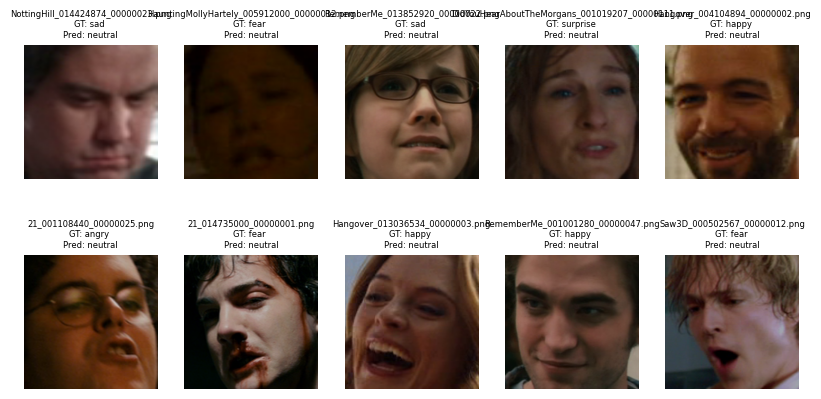

EPOCH: 2  of  150
epoch = 2...in training function


Loss=0.15968813002109528 Accuracy=321/913(35.16%) Epoch Avg loss=0.10779703 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.1045, Accuracy: 180/419 (42.96%)

last correct =180 | best correct = 119
Updated the best model with correct: 180

EPOCH: 3  of  150
epoch = 3...in training function


Loss=1.6795213222503662 Accuracy=393/913(43.04%) Epoch Avg loss=0.09942600 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1110, Accuracy: 180/419 (42.96%)

last correct =180 | best correct = 180
EPOCH: 4  of  150
epoch = 4...in training function


Loss=1.9236129522323608 Accuracy=455/913(49.84%) Epoch Avg loss=0.09014586 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.27it/s]


Test / Val: Average loss: 0.1027, Accuracy: 195/419 (46.54%)

last correct =195 | best correct = 180
Updated the best model with correct: 195

EPOCH: 5  of  150
epoch = 5...in training function


Loss=2.821822166442871 Accuracy=500/913(54.76%) Epoch Avg loss=0.08344384 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.0998, Accuracy: 214/419 (51.07%)

last correct =214 | best correct = 195
Updated the best model with correct: 214

EPOCH: 6  of  150
epoch = 6...in training function


Loss=0.01324333157390356 Accuracy=467/913(51.15%) Epoch Avg loss=0.08177340 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.1056, Accuracy: 191/419 (45.58%)

last correct =191 | best correct = 214
EPOCH: 7  of  150
epoch = 7...in training function


Loss=2.1577701568603516 Accuracy=548/913(60.02%) Epoch Avg loss=0.07304333 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1073, Accuracy: 189/419 (45.11%)

last correct =189 | best correct = 214
EPOCH: 8  of  150
epoch = 8...in training function


Loss=0.026463227346539497 Accuracy=563/913(61.66%) Epoch Avg loss=0.06703536 LR=0.001000: 100%|██████████| 58/58 [00:26<00:00,  2.22it/s]


Test / Val: Average loss: 0.1032, Accuracy: 206/419 (49.16%)

last correct =206 | best correct = 214
EPOCH: 9  of  150
epoch = 9...in training function


Loss=0.9865440130233765 Accuracy=614/913(67.25%) Epoch Avg loss=0.06040135 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.28it/s]


Test / Val: Average loss: 0.1034, Accuracy: 201/419 (47.97%)

last correct =201 | best correct = 214
EPOCH: 10  of  150
epoch = 10...in training function


Loss=1.349219799041748 Accuracy=612/913(67.03%) Epoch Avg loss=0.06042025 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.29it/s]


Test / Val: Average loss: 0.1091, Accuracy: 197/419 (47.02%)

last correct =197 | best correct = 214
EPOCH: 11  of  150
epoch = 11...in training function


Loss=0.1698712855577469 Accuracy=645/913(70.65%) Epoch Avg loss=0.05254357 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.28it/s]


Test / Val: Average loss: 0.1036, Accuracy: 213/419 (50.84%)

last correct =213 | best correct = 214


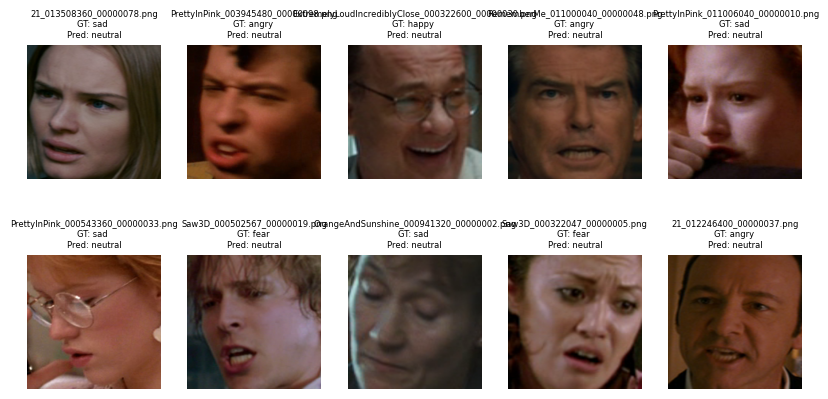

EPOCH: 12  of  150
epoch = 12...in training function


Loss=0.11537497490644455 Accuracy=651/913(71.30%) Epoch Avg loss=0.05168434 LR=0.001000: 100%|██████████| 58/58 [00:26<00:00,  2.23it/s]


Test / Val: Average loss: 0.1035, Accuracy: 205/419 (48.93%)

last correct =205 | best correct = 214
EPOCH: 13  of  150
epoch = 13...in training function


Loss=2.2982964515686035 Accuracy=679/913(74.37%) Epoch Avg loss=0.04914812 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.27it/s]


Test / Val: Average loss: 0.1099, Accuracy: 188/419 (44.87%)

last correct =188 | best correct = 214
EPOCH: 14  of  150
epoch = 14...in training function


Loss=0.6639500260353088 Accuracy=682/913(74.70%) Epoch Avg loss=0.04891782 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.29it/s]


Test / Val: Average loss: 0.1338, Accuracy: 181/419 (43.20%)

last correct =181 | best correct = 214
EPOCH: 15  of  150
epoch = 15...in training function


Loss=0.0002244459028588608 Accuracy=750/913(82.15%) Epoch Avg loss=0.03429152 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.27it/s]


Test / Val: Average loss: 0.1215, Accuracy: 202/419 (48.21%)

last correct =202 | best correct = 214
EPOCH: 16  of  150
epoch = 16...in training function


Loss=0.01515035517513752 Accuracy=759/913(83.13%) Epoch Avg loss=0.03023185 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.29it/s]


Test / Val: Average loss: 0.1146, Accuracy: 230/419 (54.89%)

last correct =230 | best correct = 214
Updated the best model with correct: 230

EPOCH: 17  of  150
epoch = 17...in training function


Loss=2.946474075317383 Accuracy=789/913(86.42%) Epoch Avg loss=0.02968816 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.29it/s]


Test / Val: Average loss: 0.1257, Accuracy: 213/419 (50.84%)

last correct =213 | best correct = 230
EPOCH: 18  of  150
epoch = 18...in training function


Loss=0.00412743678316474 Accuracy=749/913(82.04%) Epoch Avg loss=0.03469168 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.1222, Accuracy: 211/419 (50.36%)

last correct =211 | best correct = 230
EPOCH: 19  of  150
epoch = 19...in training function


Loss=4.704313278198242 Accuracy=771/913(84.45%) Epoch Avg loss=0.03259314 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.1132, Accuracy: 209/419 (49.88%)

last correct =209 | best correct = 230
EPOCH: 20  of  150
epoch = 20...in training function


Loss=1.1652041673660278 Accuracy=747/913(81.82%) Epoch Avg loss=0.03475574 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.1124, Accuracy: 209/419 (49.88%)

last correct =209 | best correct = 230
EPOCH: 21  of  150
epoch = 21...in training function


Loss=0.4913296103477478 Accuracy=789/913(86.42%) Epoch Avg loss=0.02557897 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.1260, Accuracy: 217/419 (51.79%)

last correct =217 | best correct = 230


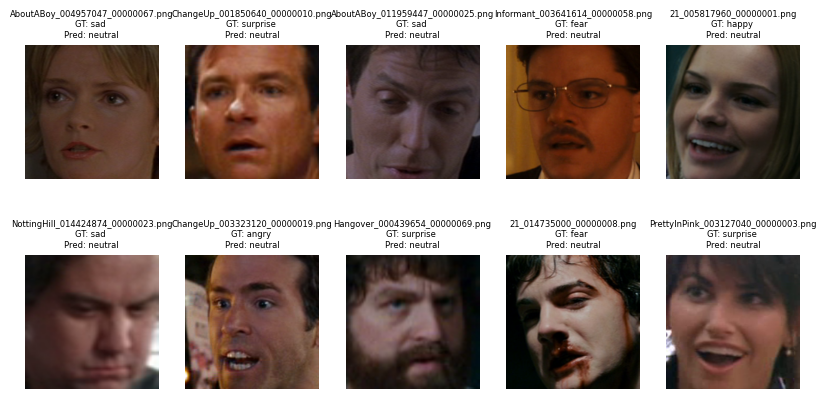

EPOCH: 22  of  150
epoch = 22...in training function


Loss=0.6971506476402283 Accuracy=807/913(88.39%) Epoch Avg loss=0.02322519 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.1344, Accuracy: 204/419 (48.69%)

last correct =204 | best correct = 230
EPOCH: 23  of  150
epoch = 23...in training function


Loss=0.0005754960584454238 Accuracy=789/913(86.42%) Epoch Avg loss=0.02510013 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.28it/s]


Test / Val: Average loss: 0.1189, Accuracy: 218/419 (52.03%)

last correct =218 | best correct = 230
EPOCH: 24  of  150
epoch = 24...in training function


Loss=0.0019126709084957838 Accuracy=817/913(89.49%) Epoch Avg loss=0.02036929 LR=0.000040: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1257, Accuracy: 215/419 (51.31%)

last correct =215 | best correct = 230
EPOCH: 25  of  150
epoch = 25...in training function


Loss=0.05952673405408859 Accuracy=834/913(91.35%) Epoch Avg loss=0.01752309 LR=0.000040: 100%|██████████| 58/58 [00:25<00:00,  2.29it/s]


Test / Val: Average loss: 0.1359, Accuracy: 214/419 (51.07%)

last correct =214 | best correct = 230
EPOCH: 26  of  150
epoch = 26...in training function


Loss=0.0022394596599042416 Accuracy=835/913(91.46%) Epoch Avg loss=0.01825332 LR=0.000040: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.1319, Accuracy: 218/419 (52.03%)

last correct =218 | best correct = 230
EPOCH: 27  of  150
epoch = 27...in training function


Loss=3.790783375734463e-05 Accuracy=820/913(89.81%) Epoch Avg loss=0.01756149 LR=0.000040: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1318, Accuracy: 214/419 (51.07%)

last correct =214 | best correct = 230
-------Early Stopping at epoch 27---
Best model loaded
Validation results with sfew
Test / Val: Average loss: 0.1119, Accuracy: 230/419 (54.89%)



In [25]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model_local_lr (model = model,
                                          device = device,
                                          data_loader = data_loader['source']['train'],
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    #Validate Model
    correct, avg_epoch_val_loss = test_model_local(model= model,
                                    device= device,
                                    data_loader = data_loader['source']['val'],
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)
    list_val_correct.append(correct)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct

    # # Check if the current model has the best validation loss
    # print(f'Last Epoch Val Loss = {avg_epoch_val_loss} | Best Val Loss = {best_val_loss}' )
    # if avg_epoch_val_loss < best_val_loss:
    #   best_val_loss = avg_epoch_val_loss
    #   # save the current model state as the best model state
    #   best_model_state = deepcopy(non_dann_model.state_dict())
    #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

    # check if the current model has the best accuracy
    print (f'last correct ={correct} | best correct = {best_val_acc}')
    if correct > best_val_acc:
      best_val_acc = correct
      # save the current model state as the best model state
      best_model_state = deepcopy(model.state_dict())
      print(f'Updated the best model with correct: {correct}\n')

    list_best_val_correct.append(best_val_acc)

    # early stopping
    # if early_stopping_difference(val_losses,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    if early_stopping_difference(list_val_correct,
                                 patience = early_stop_patience,
                                 difference= early_stop_difference):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

    if early_stopping_difference(list_best_val_correct,
                                 patience = 2*early_stop_patience,
                                 difference= 0):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break



    ## showing misclassification images after every 10 epochs
    if epoch % 10 == 0:
      list_misclassified_images = get_misclassified_images_list(model= model,
                                                                device = device,
                                                                test_loader = data_loader['source']['val'],
                                                                num_image = 10)
      plot_misclassified_images(list_misclassified_images)

## using params of best model to update model
if best_model_state: # only update if best model has been saved, else the last one would be picked up
  # best_non_dann_model.load_state_dict(best_model_state)
  best_model.load_state_dict(best_model_state)
  print('Best model loaded')


print(f'Validation results with {source_name}')

correct, test_loss_source = test_model_local(model= best_model, #best_non_dann_model, #non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'], # source val loader
                                    class_loss_function = criterion_class)


dict_non_dann_losses = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                      #  'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}


### Validation on Test Dataset - only when data loader is avaialable



In [71]:

test_model_local(model= best_model,
                            device= device,
                            data_loader = data_loader['target']['val'], # target val loader
                            class_loss_function = runconfig.criterion_class)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test / Val: Average loss: 0.2361, Accuracy: 2606/8458 (30.81%)



(2606, 0.2360771239212597)

### Model Performance Metrics

In [57]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import pandas as pd

labels_map={0:"Angry",
            1:"Disgust",
            2:"Fear",
            3:"Happy",
            4:"Sad",
            5:"Surprise",
            6:"Neutral"}

def performance_metric(model,
                       device,
                       data_loader):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0
    true_labels = []
    predicted_labels = []

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
          images, labels = batch[0].to(device), batch[1].to(device)

          class_output,_,_  = model((images*255)) # forward pass, output = {class}
          true_labels.extend(labels.argmax(dim=1).cpu().numpy())
          predicted_labels.extend(class_output.argmax(dim=1).cpu().numpy())
    # print(f'true labels - {true_labels}')
    # print(f'predicted labels - {predicted_labels}')

    true_labels = [labels_map[int_label] for int_label in true_labels]
    predicted_labels= [labels_map[int_label] for int_label in predicted_labels]

    # Compute accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Accuracy:", accuracy)

    # Compute precision
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    print("Precision:", precision)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_names = list(labels_map.values())
    cm_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(cm_df)

    # Generate classification report
    class_report = classification_report(true_labels, predicted_labels)
    print("Classification Report:")
    print(class_report)

    return true_labels, predicted_labels, accuracy, precision, cm_df, class_report



In [58]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= best_model,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.548926014319809
Precision: 0.5292305430089087
Confusion Matrix:
[[51  5  3  5  5  5  1]
 [ 1  4  0  6  3  6  2]
 [10  1  9  3  7  4  9]
 [ 3  0  0 66  1  1  1]
 [12  0  2  8 21  7  2]
 [ 9  2  7  2  7 50  7]
 [ 4  2  6  7 11 12 29]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        51        5     3      5    5         5        1
Disgust       1        4     0      6    3         6        2
Fear         10        1     9      3    7         4        9
Happy         3        0     0     66    1         1        1
Sad          12        0     2      8   21         7        2
Surprise      9        2     7      2    7        50        7
Neutral       4        2     6      7   11        12       29
Classification Report:
              precision    recall  f1-score   support

       Angry       0.57      0.68      0.62        75
     Disgust       0.29      0.18      0.22        22
        Fear       0.33      0.21      0.26        43
       Happy       

### Saving Non-Dann Model

In [26]:
target_name = 'expw'
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
SPECIFIC_MODEL_DIR = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}'))
print(MODEL_DIR, NON_DANN_SFEW_DIR, SPECIFIC_MODEL_DIR)

/content/gdrive/MyDrive/CV_FER/models /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw


In [27]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not SPECIFIC_MODEL_DIR.exists():
    # Create the directory
    SPECIFIC_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {SPECIFIC_MODEL_DIR} created successfully.')
else:
    print(f'Directory {SPECIFIC_MODEL_DIR} already exists.')

torch.save(best_model.state_dict(), Path(SPECIFIC_MODEL_DIR,model_name))

Directory /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw already exists.


In [28]:
model_name

'non_dann_sfew_expw_14_04.pt'

## Dataset - Target

- EXPW dataset

In [29]:
# checking the mounted drive and mounting if not done
import os
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")


Google Drive is already mounted.


### Creating Dataloader for EXPW

In [30]:
from da_cv_fer.ds_expw_crop_race import EXPWCROPRACE

expw_obj = EXPWCROPRACE()

expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

desitination file path = dataset/expwds/expwds.zip
Directory dataset/expwds created successfully.


100%|██████████| 7.68G/7.68G [01:39<00:00, 82.8MB/s]



File downloaded successfully from https://www.kaggle.com/datasets/mohammedaaltaha/expwds to dataset/expwds/expwds.zip
Unzipped Files already exist in dataset/expwds, not extracted
---NOT CROPPING AT RUNTIME --
 before splitting : image_label_dict 68096
*** Starting creation of dataset based on RACE data ***
pickle_raceds_crop_list_path:  /content/gdrive/MyDrive/CV_FER/dataset/expw_raceds_crop_image_dict.pkl
train list [('awe_family_398.jpg', 6), ('annoyed_actor_433.jpg', 3)] <class 'list'> 1000
size of dataset (list_img_label): 1000
*** Completed creation of dataset based on RACE data ***
---NOT CROPPING AT RUNTIME--, flag_create_crop_contents value: False
Directory created: dataset/expwds/cropped
**** dataset/expwds/cropped is empty***

 
23 were not able to crop
977 cropped images created in cropped
---NOT CROPPING AT RUNTIME --
 before splitting : image_label_dict 68096
*** Starting creation of dataset based on RACE data ***
pickle_raceds_crop_list_path:  /content/gdrive/MyDrive/CV

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [32]:
if expw_train_loader is None:
  sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
  data_loader = {'source' : sfew_loader}
  source_name = data_loader['source']['name']
  target_name = "expw"
else:
  sfew_loader = {'name': 'sfew',
                'train':sfew_train_loader,
                'val':sfew_val_loader
                }

  expw_loader = {'name': 'expw',
                'train':expw_train_loader,
                'val':expw_val_loader
                }

  data_loader = {'source' : sfew_loader,
                'target' : expw_loader}

  source_name = data_loader['source']['name']
  target_name = data_loader['target']['name']

## Loading NON DANN Model for DANN and DANN EWC


In [36]:
today_model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # Typical - non_dann_sfew_expw_30_01.pt This may change, use specific model name if required4
print(f'today_model_name {today_model_name}')
custom_model_name= 'non_dann_sfew_expw_08_04.pt'
print(f'custom_model_name {custom_model_name}')

model_name = today_model_name

print("\n****model name that would be used for loading: ", model_name)

today_model_name non_dann_sfew_expw_14_04.pt
custom_model_name non_dann_sfew_expw_08_04.pt

****model name that would be used for loading:  non_dann_sfew_expw_14_04.pt


### Loading Structure of Models

In [37]:

import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F


class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model


model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()
        y = self.avg_pool(x).view(batch_size, num_channels)
        y = self.fc(y).view(batch_size, num_channels, 1, 1)
        return x * y.expand_as(x)

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG_SE(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG_SE, self).__init__()
        #---------------------Feature Extractor Network------------------------#
        list_feature_extractor = list(model_pretrained.children())[:-4]

        # SE Block
        self.se_block = SEBlock(512)
        list_feature_extractor.insert(-1,  self.se_block)
        self.feature_extractor = nn.Sequential(*list_feature_extractor)


        # self.feature_extractor = nn.Sequential(*list(model_pretrained.children())[:-4])

        #---------------------Class Classifier------------------------#
        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        # self.class_classifier = nn.Sequential(*list(model_pretrained.children())[-4:])
        self.class_classifier = nn.Sequential(*list_class_classifer)



        #---------------------Domain Classifier------------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features



In [38]:
# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}', model_name))

model_dann =  DANN_VGG_SE(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy

model_dann.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))

model_dann_ewc = deepcopy(model_dann) # saves training time - check with all

# print(model_dann)

## Test Function

In [39]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images*255)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss

## DANN Execution: Training, Validating, Saving

### DANN Execution Function

In [40]:
def execute_dann(model,
                 device,
                 source_train_loader, source_val_loader,
                 target_train_loader, target_val_loader,
                 optimizer,
                 n_epochs, # total number of epochs (different from individual epoch)
                 class_loss_function = nn.CrossEntropyLoss(),
                 domain_loss_function = nn.BCEWithLogitsLoss(),
                 scheduler = None,
                 early_stop_patience = None,
                 early_stop_difference = None
                 ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr =[] # to capture lr over epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)

    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_val_acc = 0 # Initialize variable to track best accuracy
    best_model_state = None # Initialize variables to track the best model state


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_batch[0] = source_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_batch[0] = target_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + (loss_source_domain + loss_target_domain) # changed the loss
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch[{}/{}] Step[{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.2f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model_local(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

        list_val_correct.append(correct)

        #Adding Scheduler #TODO: ADD SCHEDULER
        if scheduler:
          scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct


        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc) # appending the best one for early stopping



        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch_idx+1
            break # break from epoch loop

        if early_stop_patience and early_stop_difference: # early stopping based on best accuracy
          if early_stopping_difference(val_losses,
                                       patience = 2*early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch_idx+1
            break # break from epoch loop

            ## showing misclassification images after every 10 epochs
        if epoch_idx % 10 == 0:
          list_misclassified_images = get_misclassified_images_list(model= model,
                                                                    device = device,
                                                                    test_loader = source_val_loader,
                                                                    num_image = 10)
          plot_misclassified_images(list_misclassified_images)


    # Testing when the training is over - completed or early stopped
    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct, test_loss_source = test_model_local(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model_local(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses


### DANN Execution Config

In [41]:
runconfig = RunConfig()
lr_dann = runconfig.inital_lr
lr_dann = lr_dann
lr_dann = 0.001 # override
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
# n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# n_epochs =  3 # override
n_epochs = runconfig.EPOCHS

print("EPOCHS", n_epochs)


# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold
# Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference


# Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer_dann,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### DANN Execution

------------training started for DANN Model ------------------
epoch = 1...in DANN execution function


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch[1/150] Step[1/58]: loss_total=1.7746 / domain_loss_target=0.6936 / domain_loss_source=0.6906 / task_loss=0.3904 / domain_loss=1.0810 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[11/58]: loss_total=2.0456 / domain_loss_target=0.6160 / domain_loss_source=0.7278 / task_loss=0.7018 / domain_loss=1.4296 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[21/58]: loss_total=2.1774 / domain_loss_target=0.6469 / domain_loss_source=0.7094 / task_loss=0.8211 / domain_loss=1.5304 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[31/58]: loss_total=2.0518 / domain_loss_target=0.6119 / domain_loss_source=0.7053 / task_loss=0.7345 / domain_loss=1.4399 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[41/58]: loss_total=2.0435 / domain_loss_target=0.6141 / domain_loss_source=0.7067 / task_loss=0.7227 / domain_loss=1.4294 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[51/58]: loss_total=1.8352 / domain_loss_target=0.5829 / domain_loss_source=0.7688 / task_loss=0.4834 / domain_loss=1.2523 / alpha=1.00 / lr=0.001000

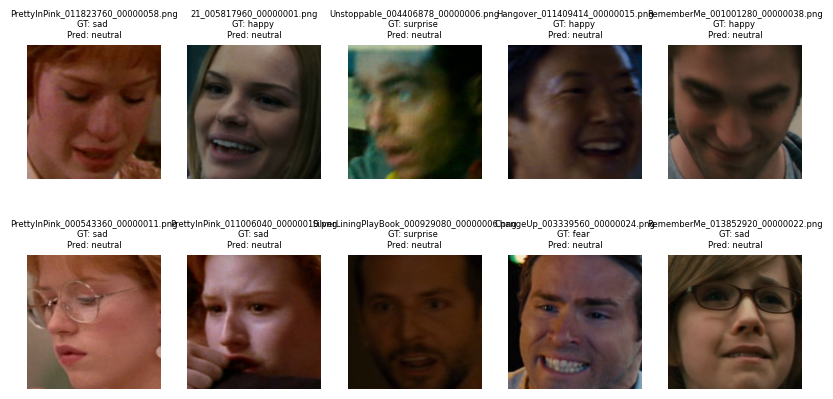

epoch = 2...in DANN execution function


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch[2/150] Step[1/58]: loss_total=2.3586 / domain_loss_target=0.6110 / domain_loss_source=0.7108 / task_loss=1.0368 / domain_loss=1.7476 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[11/58]: loss_total=1.6470 / domain_loss_target=0.6493 / domain_loss_source=0.6780 / task_loss=0.3197 / domain_loss=0.9977 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[21/58]: loss_total=2.0939 / domain_loss_target=0.7417 / domain_loss_source=0.6381 / task_loss=0.7141 / domain_loss=1.3522 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[31/58]: loss_total=2.2572 / domain_loss_target=0.7773 / domain_loss_source=0.6245 / task_loss=0.8554 / domain_loss=1.4799 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[41/58]: loss_total=1.8936 / domain_loss_target=0.6227 / domain_loss_source=0.7009 / task_loss=0.5700 / domain_loss=1.2709 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[51/58]: loss_total=1.7934 / domain_loss_target=0.7067 / domain_loss_source=0.6926 / task_loss=0.3941 / domain_loss=1.0867 / alpha=1.00 / lr=0.001000

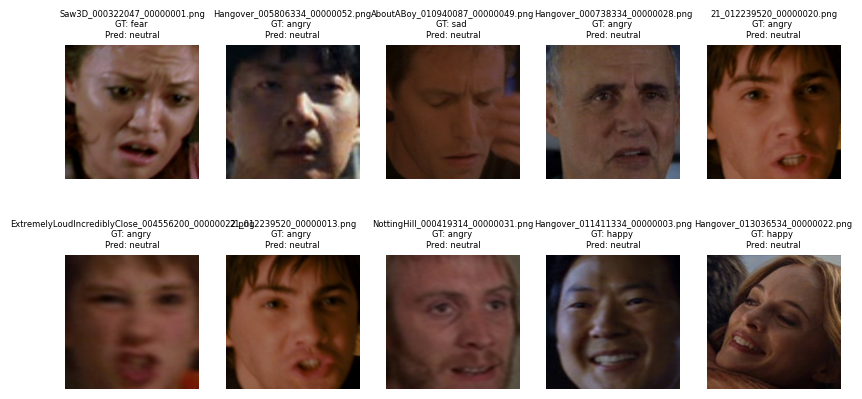

epoch = 12...in DANN execution function
Epoch[12/150] Step[1/58]: loss_total=1.9154 / domain_loss_target=0.7976 / domain_loss_source=0.5899 / task_loss=0.5278 / domain_loss=1.1178 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[11/58]: loss_total=1.6116 / domain_loss_target=0.7403 / domain_loss_source=0.6635 / task_loss=0.2079 / domain_loss=0.8713 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[21/58]: loss_total=1.8872 / domain_loss_target=0.6557 / domain_loss_source=0.6367 / task_loss=0.5948 / domain_loss=1.2315 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[31/58]: loss_total=2.3796 / domain_loss_target=0.7034 / domain_loss_source=0.7049 / task_loss=0.9713 / domain_loss=1.6762 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[41/58]: loss_total=1.5792 / domain_loss_target=0.6949 / domain_loss_source=0.6827 / task_loss=0.2016 / domain_loss=0.8842 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[51/58]: loss_total=2.0519 / domain_loss_target=0.6818 / domain_loss_source=0.6828 / task_loss=0.6872 /

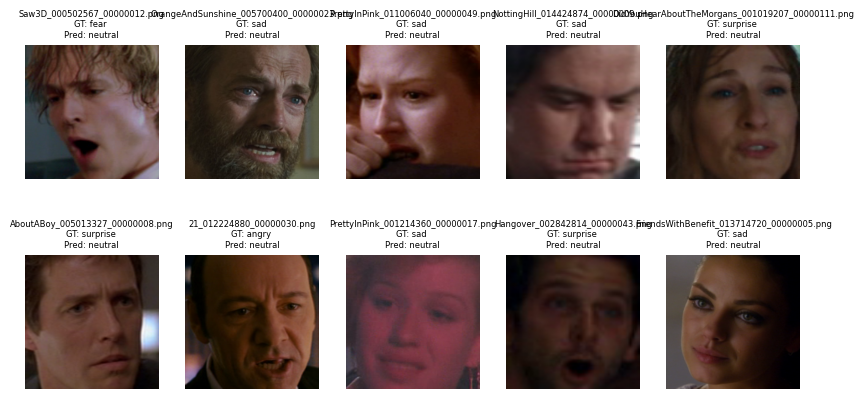

epoch = 22...in DANN execution function
Epoch[22/150] Step[1/58]: loss_total=1.6793 / domain_loss_target=0.6749 / domain_loss_source=0.7053 / task_loss=0.2990 / domain_loss=1.0043 / alpha=1.00 / lr=0.000040
Epoch[22/150] Step[11/58]: loss_total=1.4533 / domain_loss_target=0.7116 / domain_loss_source=0.6763 / task_loss=0.0654 / domain_loss=0.7416 / alpha=1.00 / lr=0.000040
Epoch[22/150] Step[21/58]: loss_total=1.4013 / domain_loss_target=0.6886 / domain_loss_source=0.6414 / task_loss=0.0713 / domain_loss=0.7127 / alpha=1.00 / lr=0.000040
Epoch[22/150] Step[31/58]: loss_total=1.5013 / domain_loss_target=0.7080 / domain_loss_source=0.6451 / task_loss=0.1482 / domain_loss=0.7933 / alpha=1.00 / lr=0.000040
Epoch[22/150] Step[41/58]: loss_total=1.4597 / domain_loss_target=0.7277 / domain_loss_source=0.6452 / task_loss=0.0868 / domain_loss=0.7320 / alpha=1.00 / lr=0.000040
Epoch[22/150] Step[51/58]: loss_total=1.4690 / domain_loss_target=0.7401 / domain_loss_source=0.6636 / task_loss=0.0654 /

In [42]:
print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                    source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                    target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                    target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain,
                                                    scheduler = scheduler,
                                                    early_stop_patience = early_stop_patience,
                                                    early_stop_difference = early_stop_difference
                                                    )

### DANN Saving

In [43]:
dann_model_name = f'dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(dann_model_name)

# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'dann_{source_name}_{target_name}'))


if not DANN_MODEL_DIR.exists():
    # Create the directory
    DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {DANN_MODEL_DIR} already exists.')


try:
    torch.save(dann_model_trained.state_dict(), Path(DANN_MODEL_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_MODEL_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')

dann_sfew_expw_14_04.pt
Directory /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw already exists.
dann_sfew_expw_14_04.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw/dann_sfew_expw_14_04.pt!


### DANN Performance

In [59]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= dann_model_trained,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.5298329355608592
Precision: 0.5044268103697397
Confusion Matrix:
[[43  4  2  3  5 11  7]
 [ 2  4  1  6  2  3  4]
 [ 4  2  5  2 11  7 12]
 [ 2  0  0 62  0  2  6]
 [12  0  5  4 12 10  9]
 [ 3  0  4  3  4 53 17]
 [ 4  0  2  5  6 11 43]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        43        4     2      3    5        11        7
Disgust       2        4     1      6    2         3        4
Fear          4        2     5      2   11         7       12
Happy         2        0     0     62    0         2        6
Sad          12        0     5      4   12        10        9
Surprise      3        0     4      3    4        53       17
Neutral       4        0     2      5    6        11       43
Classification Report:
              precision    recall  f1-score   support

       Angry       0.61      0.57      0.59        75
     Disgust       0.40      0.18      0.25        22
        Fear       0.26      0.12      0.16        43
       Happy      

## EWC DANN Execution: Training, Validating, Saving


In [60]:
model_dann_ewc


DANN_VGG_SE(
  (se_block): SEBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=512, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=512, bias=True)
      (3): Sigmoid()
    )
  )
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 

### EWC Code
- Regularization Penalty

In [61]:
from torch.autograd import Variable
from torch.autograd import Function
from da_cv_fer.run_config import RunConfig

runconfig = RunConfig()
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module,
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function

        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        # for n, p in deepcopy(self.params).items():
        for n, p in self.params.items():

            self._means[n] = variable(p.data)

        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            batch[0] = batch[0]* 255.0
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = self.model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### EWC DANN Execution Function

In [64]:
def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     scheduler = None,
                     early_stop_patience = None,
                     early_stop_difference = None
                     ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr = [] # to capture lr changes across epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    model = model.to(device)
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    # scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

    ewc_object = EWC(existing_model.to(device),
                     data_loader=source_train_loader,
                     device=device,
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_model_state = None # Initialize variables to track the best model state
    best_val_acc = 0 # Initialize variables to track the best accuracy


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)


            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_batch[0] = source_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_batch[0] = target_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)


            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model_local(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)
        list_val_correct.append(correct)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')


        #Scheduler
        if scheduler:
          scheduler.step(correct) ## applying scheduler on correct, proxy to accuracy

        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc)

        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch_idx + 1}---')
            epoch_converge = epoch_idx +1
            break # break from epoch loop
        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required based on best accuracy
          if early_stopping_difference(list_best_val_correct,
                                       patience = 2* early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch_idx +1}---')
            epoch_converge = epoch_idx +1
            break # break from epoch loop

    # Testing when the training is over - completed or early stopped

    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct_source, test_loss_source = test_model_local(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)

    correct_target, test_loss_target = test_model_local(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    accuracy_target = correct_target / len(target_val_loader.dataset)


    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target,
                            'lr':list_lr}

    # print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses



### EWC DANN Execution Config

In [65]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr #override
lr_ewc_dann = 0.001 #override

optimizer_ewc_dann = optim.SGD(model_dann_ewc.parameters(), lr = lr_ewc_dann, momentum = 0.9)
# n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# n_epochs = 40 # override
# n_epochs =  3 # override
n_epochs = runconfig.EPOCHS

print("EPOCHS", n_epochs)

# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold

# # Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference


# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# # Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)


EPOCHS 150
0.4


### EWC DANN Execution

In [66]:
print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model , dict_ewc_dann_losses = execute_dann_ewc(model= model_dann_ewc,
                                                          device=device,
                                                          source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                          source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                          target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                          target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                          optimizer = optimizer_ewc_dann,
                                                          n_epochs = n_epochs,
                                                          class_loss_function = runconfig.criterion_class,
                                                          domain_loss_function = runconfig.criterion_domain,
                                                          EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                          scheduler = scheduler,
                                                          early_stop_patience = early_stop_patience,
                                                          early_stop_difference = early_stop_difference
                                                         )

------------training started for EWC DANN Model ------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch = 1...in EWC DANN execution function
Epoch [1/150] Step [1/58]: loss_total=1.6577 / domain_loss_target=0.7088 / domain_loss_source=0.6914 / task_loss=0.2575 / domain_loss=0.9489 / alpha=1.0000 / lr=0.001000
Epoch [1/150] Step [51/58]: loss_total=1.9486 / domain_loss_target=0.6817 / domain_loss_source=0.6999 / task_loss=0.5670 / domain_loss=1.2669 / alpha=1.0000 / lr=0.001000
Test / Val: Average loss: 0.1199, Accuracy: 200/419 (47.73%)

last correct =200 | best correct = 0
Updated the best model with correct: 200

epoch = 2...in EWC DANN execution function
Epoch [2/150] Step [1/58]: loss_total=2.1895 / domain_loss_target=0.6413 / domain_loss_source=0.6961 / task_loss=0.8521 / domain_loss=1.5482 / alpha=1.0000 / lr=0.001000
Epoch [2/150] Step [51/58]: loss_total=1.5914 / domain_loss_target=0.6527 / domain_loss_source=0.7227 / task_loss=0.2160 / domain_loss=0.9387 / alpha=1.0000 / lr=0.001000
Test / Val: Average loss: 0.1244, Accuracy: 209/419 (49.88%)

last correct =209 | best corr

### EWC DANN Saving

In [67]:
# ewc_dann_model_name = 'ewc_dann_sfew_expw_30_01.pt'
ewc_dann_model_name = f'ewc_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(ewc_dann_model_name)

from da_cv_fer.data_config import DataConfig
dataconfig_2 = DataConfig()
MODEL_DIR = dataconfig_2.MODEL_DIR


EWC_DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'ewc_dann_{source_name}_{target_name}'))



if not EWC_DANN_MODEL_DIR.exists():
    # Create the directory
    EWC_DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_MODEL_DIR} already exists.')

try:
    torch.save(ewc_dann_model.state_dict(), Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')

ewc_dann_sfew_expw_14_04.pt
Directory /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw already exists.
ewc_dann_sfew_expw_14_04.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw/ewc_dann_sfew_expw_14_04.pt!


### EWC DANN Performance

In [69]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= ewc_dann_model,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.513126491646778
Precision: 0.5315814848461875
Confusion Matrix:
[[61  2  0  4  2  4  2]
 [ 3  2  0  7  3  5  2]
 [20  0 10  1  8  0  4]
 [ 6  0  0 58  5  3  0]
 [19  1  4  2 23  2  1]
 [21  0  2  3 14 35  9]
 [13  1  6  6 12  7 26]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        61        2     0      4    2         4        2
Disgust       3        2     0      7    3         5        2
Fear         20        0    10      1    8         0        4
Happy         6        0     0     58    5         3        0
Sad          19        1     4      2   23         2        1
Surprise     21        0     2      3   14        35        9
Neutral      13        1     6      6   12         7       26
Classification Report:
              precision    recall  f1-score   support

       Angry       0.43      0.81      0.56        75
     Disgust       0.33      0.09      0.14        22
        Fear       0.45      0.23      0.31        43
       Happy       